In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")


In [ ]:

df = pd.read_csv('/content/appl.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)
data = df[['Close']].copy()
for lag in range(1, 6):
    data[f'lag_{lag}'] = data['Close'].shift(lag)
data['Target'] = data['Close'].shift(-1)

data.dropna(inplace=True)

feature_cols = [f'lag_{i}' for i in range(1, 6)]
X = data[feature_cols]
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    acc = 100 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n{name} Results:")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"Accuracy: {acc:.2f}%")
    return mse, rmse, r2, acc


In [ ]:

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
evaluate_model("Linear Regression", y_test, lr_pred)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
evaluate_model("Random Forest", y_test, rf_pred)

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
evaluate_model("XGBoost", y_test, xgb_pred)



Linear Regression Results:
MSE:  6.6353
RMSE: 2.5759
R²:   0.9965
Accuracy: 98.01%

Random Forest Results:
MSE:  4017.0918
RMSE: 63.3805
R²:   -1.1067
Accuracy: 59.39%

XGBoost Results:
MSE:  4019.3305
RMSE: 63.3982
R²:   -1.1078
Accuracy: 59.34%


(4019.3304929902715,
 np.float64(63.39818998197245),
 -1.1078342935671412,
 np.float64(59.338592660095415))

In [ ]:

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

lstm_pred = lstm_model.predict(X_test_lstm).flatten()
evaluate_model("LSTM", y_test, lstm_pred)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

LSTM Results:
MSE:  4174.5429
RMSE: 64.6107
R²:   -1.1892
Accuracy: 56.91%


(4174.542931956974,
 np.float64(64.61070292108711),
 -1.189231457152665,
 np.float64(56.91011057388769))

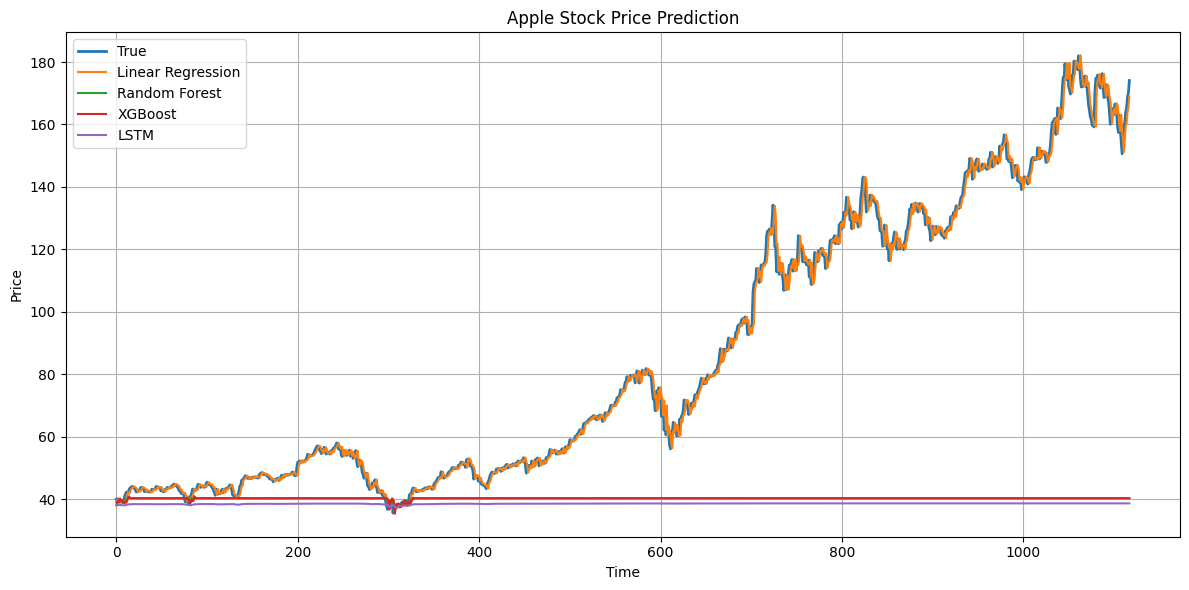

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='True', linewidth=2)
plt.plot(lr_pred, label='Linear Regression')
plt.plot(rf_pred, label='Random Forest')
plt.plot(xgb_pred, label='XGBoost')
plt.plot(lstm_pred, label='LSTM')
plt.title("Apple Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

df = pd.read_csv('/content/appl.csv')


df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

data = df[['Close']].copy()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [ ]:

def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_data, window_size)


split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [ ]:

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 7.6431e-04 - val_loss: 2.8803e-05
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 4.8862e-05 - val_loss: 3.3411e-05
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.6418e-05 - val_loss: 4.8051e-05
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.0032e-05 - val_loss: 3.3003e-05
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.8377e-05 - val_loss: 2.0667e-05
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.9160e-05 - val_loss: 1.3724e-05
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.5308e-05 - val_loss: 7.6996e-05
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.5432e-05 - val_loss: 2.9628e-05
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.2449e-05 - val_loss: 1.6314e-05
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.3883e-05 - val_loss: 4.7406e-05
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/